In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np

For the further analysis I will use a dataset containing 1272 detective novels, written by 40 authors: 

In [2]:
eda_df = pd.read_csv('/Users/eiwi/GA_stuff/GA_lessons/DSI11-lessons/projects/project-capstone/full_texts_df_iter1_40.csv')

In [3]:
eda_df.head(3)

,Unnamed: 0,book_authors,book_titles,book_url,book_lang,book_pages,book_type,book_text
0,0,Grant Allen,Falling in Love / With Other Essays on More Ex...,j0T1dljs,en,423,Book,\n\n\n\n\n\nThe Project Gutenberg EBook of Fal...
1,1,Grant Allen,An African Millionaire / Episodes in the Life ...,WVGrDdOB,en,247,Book,\n\n\n\n\n\nThe Project Gutenberg EBook of An ...
2,2,Grant Allen,Miss Cayley's Adventures,PTu1Toxw,en,386,Book,\n\n\n\n\n\nThe Project Gutenberg EBook of Mis...


In [4]:
# Since some of the scraped books have actualy been just the placeholder empty files, I  need to drop null values

eda_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1272 entries, 0 to 1271
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    1272 non-null   int64 
 1   book_authors  1272 non-null   object
 2   book_titles   1272 non-null   object
 3   book_url      1272 non-null   object
 4   book_lang     1272 non-null   object
 5   book_pages    1272 non-null   int64 
 6   book_type     1272 non-null   object
 7   book_text     1266 non-null   object
dtypes: int64(2), object(6)
memory usage: 79.6+ KB


In [5]:
eda_df.dropna(inplace = True)
eda_df.drop_duplicates(inplace = True)
eda_df.reset_index(drop = True, inplace = True)

## Extracting clean paragraphs

While inspecting the cells containing books' full text, I have noticed what should be cleaned, such as:

- Special characters (like '\n')
- Standard licensing text
- Chapter names (capitalised text)
- Contractions
- Page numbers and other digits (including years)

In order not to give a model any hins I will also rule out the following items with RegEx:
- Personal names
- Geographical names


In [6]:
eda_df.book_text[2]

'\n\n\n\n\n\nThe Project Gutenberg EBook of Miss Cayley\'s Adventures, by Grant Allen\nThis eBook is for the use of anyone anywhere at no cost and with\nalmost no restrictions whatsoever.  You may copy it, give it away or\nre-use it under the terms of the Project Gutenberg License included\nwith this eBook or online at www.gutenberg.org\nTitle: Miss Cayley\'s Adventures\nAuthor: Grant Allen\nIllustrator: Gordon Browne\nRelease Date: January 15, 2010 [EBook #30970]\nLanguage: English\n*** START OF THIS PROJECT GUTENBERG EBOOK MISS CAYLEY\'S ADVENTURES ***\nProduced by Annie McGuire. This book was produced from\nscanned images of public domain material from the Google\nPrint project.\n RECENT FICTION\nBy A. Conan Doyle.\nA Duet. 6s.\nBy Grant Allen.\nAn African Millionaire. 6s.\nLinnet. 6s.\nBy Frederic Breton.\nTrue Heart. 6s.\n\'God Save England!\' 6s.\nBy M. P. Shiel.\nContraband of War. 6s.\nThe Yellow Danger. 6s.\nBy Grammont Hamilton.\nThe Mayfair Marriage. 6s.\nBy Haldane MacFall.

In [7]:
# The list has been  kindly provided in the article https://towardsdatascience.com/
# a-practitioners-guide-to-natural-language-processing-part-i-processing-understanding-text-9f4abfd13e72

contraction_map = {
"ain’t": "is not",
"aren’t": "are not",
"can’t": "cannot",
"can’t’ve": "cannot have",
"’cause": "because",
"could’ve": "could have",
"couldn’t": "could not",
"couldn’t’ve": "could not have",
"didn’t": "did not",
"doesn’t": "does not",
"don’t": "do not",
"dont": "do not",
"hadn’t": "had not",
"hadn’t’ve": "had not have",
"hasn’t": "has not",
"haven’t": "have not",
"he’d": "he would",
"he’d’ve": "he would have",
"he’ll": "he will",
"he’ll’ve": "he he will have",
"he’s": "he is",
"how’d": "how did",
"how’d’y": "how do you",
"how’ll": "how will",
"how’s": "how is",
"I’d": "I would",
"I’d’ve": "I would have",
"I’ll": "I will",
"I’ll’ve": "I will have",
"I’m": "I am",
"I’ve": "I have",
"i’d": "i would",
"i’d’ve": "i would have",
"i’ll": "i will",
"i’ll’ve": "i will have",
"i’m": "i am",
"i’ve": "i have",
"isn’t": "is not",
"it’d": "it would",
"it’d’ve": "it would have",
"it’ll": "it will",
"it’ll’ve": "it will have",
"it’s": "it is",
"let’s": "let us",
"ma’am": "madam",
"mayn’t": "may not",
"might’ve": "might have",
"mightn’t": "might not",
"mightn’t’ve": "might not have",
"must’ve": "must have",
"mustn’t": "must not",
"mustn’t’ve": "must not have",
"needn’t": "need not",
"needn’t’ve": "need not have",
"o’clock": "of the clock",
"oughtn’t": "ought not",
"oughtn’t’ve": "ought not have",
"shan’t": "shall not",
"sha’n’t": "shall not",
"shan’t’ve": "shall not have",
"she’d": "she would",
"she’d’ve": "she would have",
"she’ll": "she will",
"she’ll’ve": "she will have",
"she’s": "she is",
"should’ve": "should have",
"shouldn’t": "should not",
"shouldn’t’ve": "should not have",
"so’ve": "so have",
"so’s": "so as",
"that’d": "that would",
"that’d’ve": "that would have",
"that’s": "that is",
"there’d": "there would",
"there’d’ve": "there would have",
"there’s": "there is",
"they’d": "they would",
"they’d’ve": "they would have",
"they’ll": "they will",
"they’ll’ve": "they will have",
"they’re": "they are",
"they’ve": "they have",
"to’ve": "to have",
"wasn’t": "was not",
"we’d": "we would",
"we’d’ve": "we would have",
"we’ll": "we will",
"we’ll’ve": "we will have",
"we’re": "we are",
"we’ve": "we have",
"weren’t": "were not",
"what’ll": "what will",
"what’ll’ve": "what will have",
"what’re": "what are",
"what’s": "what is",
"what’ve": "what have",
"when’s": "when is",
"when’ve": "when have",
"where’d": "where did",
"where’s": "where is",
"where’ve": "where have",
"who’ll": "who will",
"who’ll’ve": "who will have",
"who’s": "who is",
"who’ve": "who have",
"why’s": "why is",
"why’ve": "why have",
"will’ve": "will have",
"won’t": "will not",
"won’t’ve": "will not have",
"would’ve": "would have",
"wouldn’t": "would not",
"wouldn’t’ve": "would not have",
"y’all": "you all",
"y’all’d": "you all would",
"y’all’d’ve": "you all would have",
"y’all’re": "you all are",
"y’all’ve": "you all have",
"you’d": "you would",
"you’d’ve": "you would have",
"you’ll": "you will",
"you’ll’ve": "you will have",
"you’re": "you are",
"you’ve": "you have"
}

In [8]:
## Cleaning all books full text cells altogether + separating text into paragraphs (lines)

general_list_of_lines = [] # These lists will become the columns in the new DF, 
general_list_of_authors = [] # where the number of datapoints equals to the number of all paragraphs

pattern_names = re.compile(r'[A-Z][a-z]+', flags=re.MULTILINE) 
pattern_numbers = re.compile(r"[0-9]", flags=re.MULTILINE) 
pattern_symbols = re.compile(r'[\\^$|?*+()#][n(?=//)]', flags= re.MULTILINE) 


for i in range(len(eda_df)):
    author = eda_df.book_authors[i]
    book = eda_df.book_text[i]
    list_of_lines = book.split('\n') # here the individual lines are extracted
    for line in list_of_lines:
        access_denied = '"error":{"code":403,"message":"Access denied"}}'
        if (len(line) < 300) or (line.isupper() == True) or (access_denied in line) or ('gutenberg' in line) or ('bodybody' in line)  or ('margin' in line):
            list_of_lines.remove(line)
        else:
            
            for key,value in contraction_map.items():  # getting rid of contractions
                if key in line:
                    new_line = line.replace(key, value) 
                    
            names = re.findall(pattern_names, line) # getting rid of presonal/ geographical names
            for name in names:
                line = line.replace(name,'')
                
            numbers = re.findall(pattern_numbers, line) # getting rig of years and single digits
            for number in numbers:
                line = line.replace(number,'')
                
            symbols = re.findall(pattern_symbols, line) # getting rid of special symbols
            for symbol in symbols:
                line = line.replace(symbol,'')
                 
            line = line.replace('\xa0', '') # getting rid of special characters
            line = line.replace("'s", "")
            line = line.replace("'", '')
            line = line.replace('"', '')
            
                
            general_list_of_authors.append(author)
            general_list_of_lines.append(line)
        

## Saving a new DataFrame that represents all the paragraphs

In [9]:
lines_df = pd.DataFrame()

lines_df['book_author'] = general_list_of_authors
lines_df['book_line'] = general_list_of_lines

In [11]:
lines_df['len_line'] = [len(line) for line in lines_df.book_line]

In [12]:
lines_df.head()

,book_author,book_line,len_line
0,Grant Allen,"people complain that science is dry. is, of ...",325
1,Grant Allen,"the specimens here selected for exhibition, m...",336
2,Grant Allen,ancient and famous human institution is in pr...,1469
3,Grant Allen,"this is of course a serious subject, and it o...",1139
4,Grant Allen,"in , as modern biology teaches us to believe,...",1280


In [14]:
# It turned out that some books are not in English, despite the tag 'en' in eda_df.book_lang column, 
# so I will drop them too.

indices_not_eng = []

for i in range(len(lines_df.book_line)):
    line = lines_df.book_line[i]
    if (('the' not in line) and ('he' not in line) and ('I' not in line) and ('you' not in line) and ('of' not in line)):
        indices_not_eng.append(i)

In [16]:
lines_df.iloc[indices_not_eng].book_line.head(10)

42404     |   | |   | |   | |   | |   | |   | |   | |   ...
43062     |   | |   | |   | |   | |   | |   | |   | |   ...
132449     ,   , employed with   , went out from his pos...
150941    “N’ai-je pas toujours su, d’ailleurs, que tu d...
150942    “ foi, non, ma chère, jamais je n’ai eu la moi...
150944    “D’ailleurs, cela ne pouvait durer. Déjà un so...
165143      ‡ ‡ †    ) )  * ;     )  ‡ . )  ‡ ) ;    * ;...
172552    “     ) )  * ;     )  )  ) ;    * ;    ¶   ) )...
173945     , es un largo poema escrito por    que fue pu...
179498    सभी अधिकार सुरक्षित। हेरिटेज बुक्स के लेखन में...
Name: book_line, dtype: object

In [17]:
lines_df.drop(index = indices_not_eng, inplace = True)
lines_df.reset_index(drop = True, inplace = True)

### How many books are there for each author?

In [18]:
auth_books = eda_df[['book_authors','book_titles']].groupby('book_authors').count().sort_values(by ='book_titles', ascending=False)

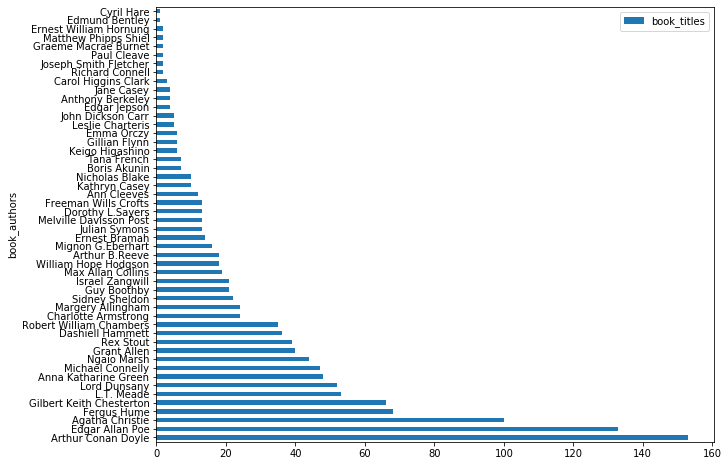

In [19]:
auth_books.plot(kind = 'barh', figsize = (10,8) )
plt.show()

Despite the fact the number of books is very different, I will not reduce the amount of books.
Instead I wiill pick the paragraphs (lines) randomly from all author's books.

### Can we consider the paragraphs more or less equal in terms of length?

In [20]:
auth_len_lines_mean = lines_df[['book_author','len_line']].groupby('book_author').mean().sort_values(by ='len_line', ascending=False)

In [21]:
auth_len_lines_mean

,len_line
book_author,
Gilbert Keith Chesterton,998.992830
Grant Allen,867.257657
Edgar Allan Poe,859.694050
Israel Zangwill,810.768048
Graeme Macrae Burnet,741.579710
Edmund Bentley,713.797980
Lord Dunsany,694.152274
Arthur Conan Doyle,685.616671
Ernest Bramah,669.612511


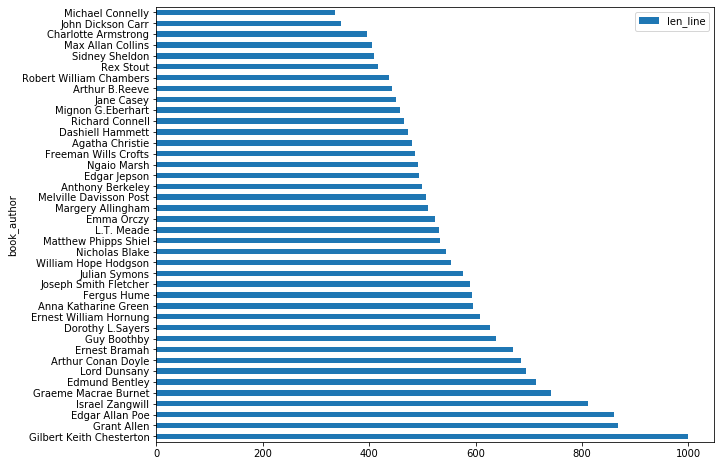

In [22]:
# Average length of lines

auth_len_lines_mean.plot(kind = 'barh', figsize = (10,8) )

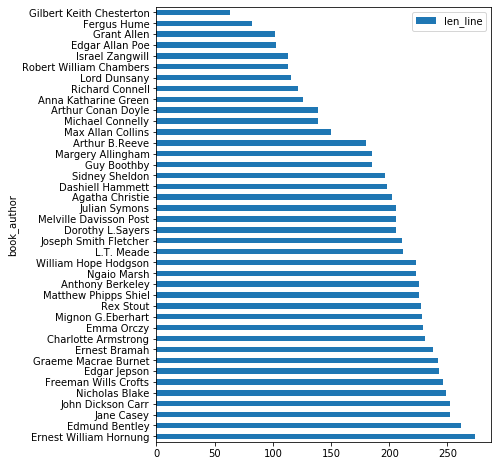

In [23]:
# Minimal length of lines

lines_df[['book_author','len_line']].groupby('book_author').min().sort_values(by ='len_line', ascending=False).plot(kind = 'barh', figsize = (6,8))

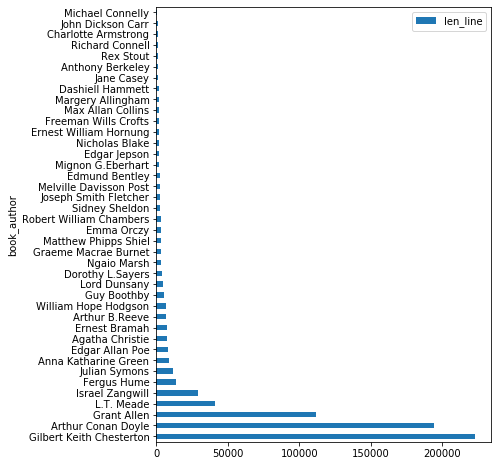

In [24]:
# Maximal length of lines

lines_df[['book_author','len_line']].groupby('book_author').max().sort_values(by ='len_line', ascending=False).plot(kind = 'barh', figsize = (6,8))

In order to make dataset most homogenious possible, I will keep the paragraphs length between 300 and 600 characters

In [25]:
lines_df = lines_df[(lines_df.len_line >= 300) & (lines_df.len_line <= 600)]
lines_df.reset_index(drop = True, inplace = True)

In [26]:
lines_df.describe()

,len_line
count,116437.000000
mean,421.263026
std,85.128742
min,300.000000
25%,347.000000
50%,407.000000
75%,489.000000
max,600.000000


In [27]:
# The average length of the paragraphs for each author now changed:

new_auth_len_lines_mean = lines_df[['book_author','len_line']].groupby('book_author').mean().sort_values(by ='len_line', ascending=False)
new_auth_len_lines_mean

,len_line
book_author,
Edmund Bentley,439.022059
Edgar Allan Poe,437.117638
Graeme Macrae Burnet,434.127517
Gilbert Keith Chesterton,431.770051
Grant Allen,431.024831
Arthur Conan Doyle,428.966041
Israel Zangwill,428.963741
Ernest Bramah,428.092166
Julian Symons,425.096981


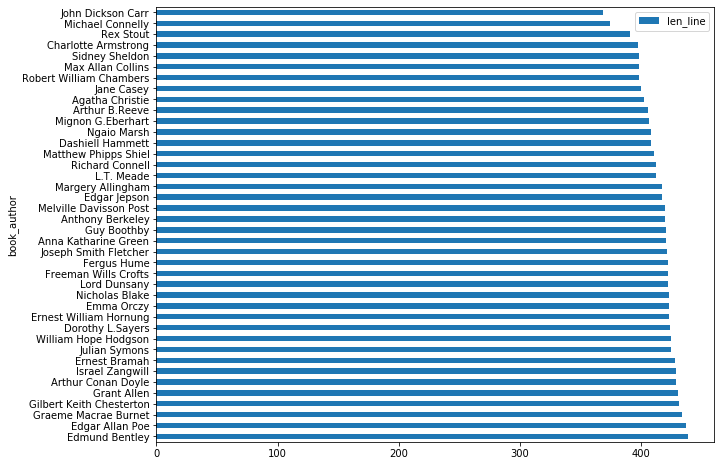

In [28]:
new_auth_len_lines_mean.plot(kind = 'barh', figsize = (10,8))

### How many paragraphs are there for each author now?

In [29]:
auth_lines = lines_df[['book_author','book_line']].groupby('book_author').count().sort_values(by ='book_line', ascending=False)

In [30]:
auth_lines

,book_line
book_author,
Arthur Conan Doyle,15136
Edgar Allan Poe,12972
Anna Katharine Green,10877
L.T. Meade,6581
Fergus Hume,6549
Grant Allen,6363
William Hope Hodgson,5894
Arthur B.Reeve,5715
Gilbert Keith Chesterton,5249


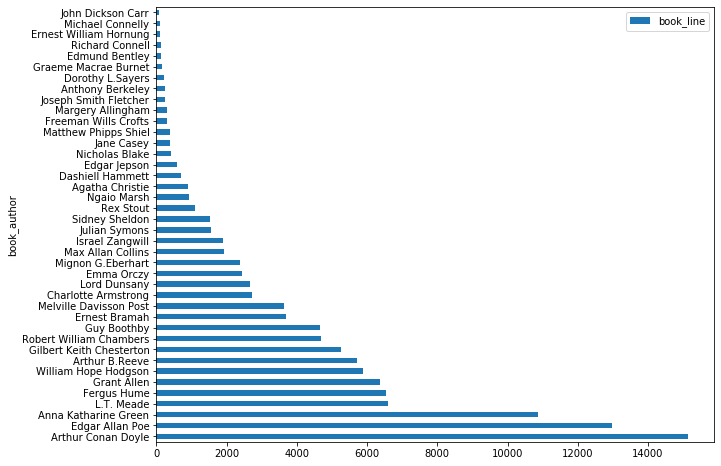

In [31]:
auth_lines.plot(kind = 'barh', figsize = (10,8) )
plt.show()

As I have decided to use as many paragraphs as teh author with the minimal number of paragraphs has, now I will pick 80 paragraphs for each of them. 

For the authors who have more than 80 paragraphs, the set of them will be picked randomly.

## Choosing random 80 lines for each author

In [32]:
new_array_of_indices = []
general_list_of_indices = []
general_list_of_names = []

for author_name in list(lines_df.book_author.unique()):
    list_of_indices = lines_df[lines_df.book_author == author_name].index
    new_list_of_indices = np.random.choice(list_of_indices, 80).tolist()
    for i in new_list_of_indices:
        general_list_of_indices.append(i)
        general_list_of_names.append(author_name)

In [35]:
selected_lines = []

for i in general_list_of_indices:
    selected_line = lines_df.book_line.iloc[i]
    selected_lines.append(selected_line)

In [36]:
final_lines_df = pd.DataFrame()
final_lines_df['book_author'] = general_list_of_names
final_lines_df['book_line'] = selected_lines
final_lines_df['len_line'] = [len(line) for line in final_lines_df['book_line']]

In [37]:
final_lines_df.describe()

,len_line
count,3200.000000
mean,414.917188
std,83.969998
min,300.000000
25%,343.000000
50%,400.000000
75%,480.000000
max,600.000000


At this point it is difficult to make any conclusions regarding authors' individual style, so I will continue EDA after creating language features.

### Saving a CSV file

In [38]:
final_lines_df.to_csv(r'/Users/eiwi/GA_stuff/GA_lessons/DSI11-lessons/projects/project-capstone/For GitHub/final_lines_df_iteration_1.csv', 
                columns = lines_df.columns)